Here we explore a tutorial provided by by Margaret Maynard-Reid on February 21, 2022

URL: https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


Dataset:

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\G5\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disab

Let's first make a few changes to the downloaded data before we start training U-Net with it.

In [3]:
# First, we need to resize the images and masks to 128x128:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask
###

# We then create a function to augment the dataset by flipping them horizontally:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask
###


# We create a function to normalize the dataset by scaling the 
#  images to the range of [-1, 1] and decreasing the image mask by 1:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask
###

In [4]:
# We create two functions to preprocess the training and 
#  test datasets with a slight difference between the two 
#  - we only perform image augmentation on the training dataset.

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask
###

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask
###

Now we are ready to build an input pipeline with tf.data by using the map() function:

In [5]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
print(train_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


We define a batch size of 64 and a buffer size of 1000 for creating batches of training and test datasets. With the  original TFDS dataset, there are 3680 training samples and 3669 test samples, which are further split into validation/test sets. We will use the train_batches and the validation_batches for training the U-Net model. After the training finishes, we will then use the test_batches to test the model predictions.

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

Now the datasets are ready for training. Let's visualize a random sample image and 
its mask from the training dataset, to get an idea of how the data looks.

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
###

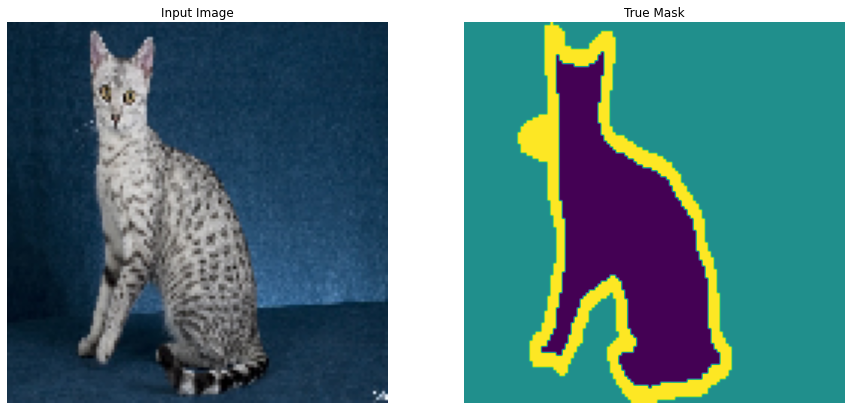

In [9]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# Model Architecture

Now that we have the data ready for training, let's define the U-Net model architecture. As mentioned earlier, the U-Net is shaped like a letter U with an encoder, decoder, and the skip connections between them. So we will create a few building blocks to make the U-Net model.

## Building blocks

First, we create a function double_conv_block with layers Conv2D-ReLU-Conv2D-ReLU , which we will use in both the encoder (or the contracting path) and the bottleneck of the U-Net

In [10]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x
###

# Then we define a downsample_block function for downsampling 
# or feature extraction to be used in the encoder.

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p
###

# Finally, we define an upsampling function upsample_block 
# for the decoder (or expanding path) of the U-Net.

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x
###

# U-Net Model

There are three options for making a Keras model, as well explained in Adrian's blog and the Keras documentation:

1) Sequential API: easiest and beginner-friendly, stacking the layers sequentially.

2) Functional API: more flexible and allows non-linear topology, shared layers, and multiple inputs or multi-outputs.

3) Model subclassing: most flexible and best for complex models that need custom training loops.

U-Net has a fairly simple architecture; however, to create the skip connections between the encoder and decoder, we will need to concatenate some layers. So the Keras Functional API is most appropriate for this purpose.

First, we create a build_unet_model function, specify the inputs, encoder layers, bottleneck, decoder layers, and finally the output layer with Conv2D with activation of softmax

- Note the input image shape is 128x128x3

- The output has three channels corresponding to the three classes that the model will classify each pixel for: background, foreground object, and object outline.


In [11]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [12]:
unet_model = build_unet_model()

In [13]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

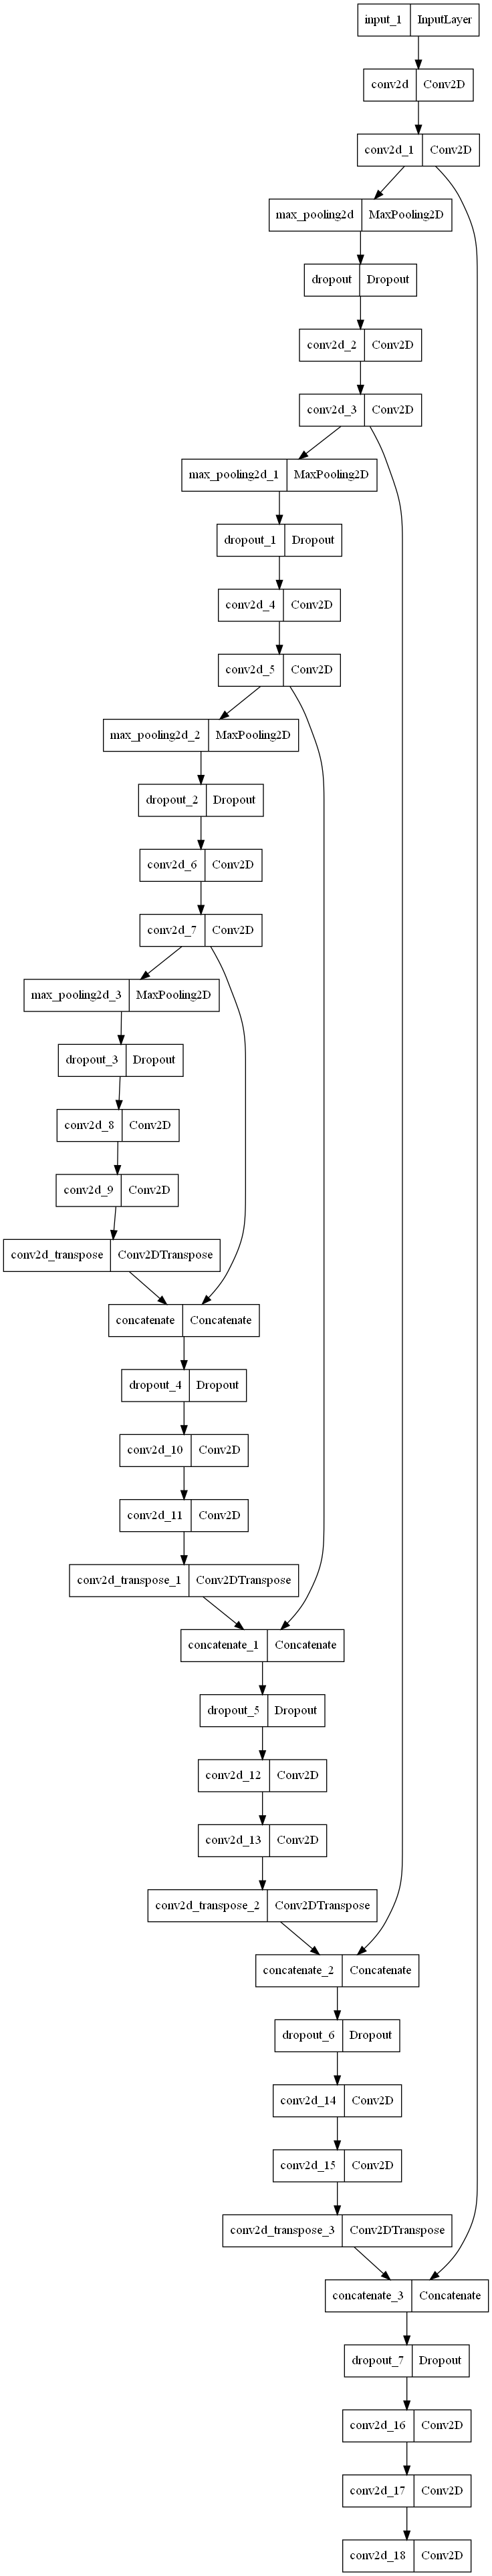

In [14]:
from tensorflow.keras import utils

utils.plot_model(unet_model)

# Compile and Train U-Net

To compile unet_model, we specify the optimizer, the loss function, and the accuracy metrics to track during training:

In [15]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [16]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS


In [19]:


train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [17]:
# model_history = unet_model.fit(train_batches,
#                               epochs=NUM_EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=test_batches)